# Importing all the data and storing it locally

In [457]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

# Function that will read all the data from .csv files and store it in a Dataframe

In [458]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Using the load function to store data in a dataframe and display the first entries
## This is mostly to check that the data has loaded correctly

In [459]:
housing = pd.read_csv('housing_data.csv')
housing_test = pd.read_csv('housing_test_data.csv')
housing.info()
housing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16344 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.13,37.67,40.0,1748.0,318.0,914.0,317.0,3.8676,184000.0,NEAR BAY
1,-120.98,37.65,40.0,422.0,63.0,158.0,63.0,7.3841,172200.0,INLAND
2,-118.37,33.87,23.0,1829.0,331.0,891.0,356.0,6.5755,359900.0,<1H OCEAN
3,-117.89,33.90,23.0,1533.0,226.0,693.0,230.0,7.8980,258200.0,<1H OCEAN
4,-122.40,37.76,52.0,1529.0,385.0,1347.0,348.0,2.9312,239100.0,NEAR BAY


# Visualizing the data

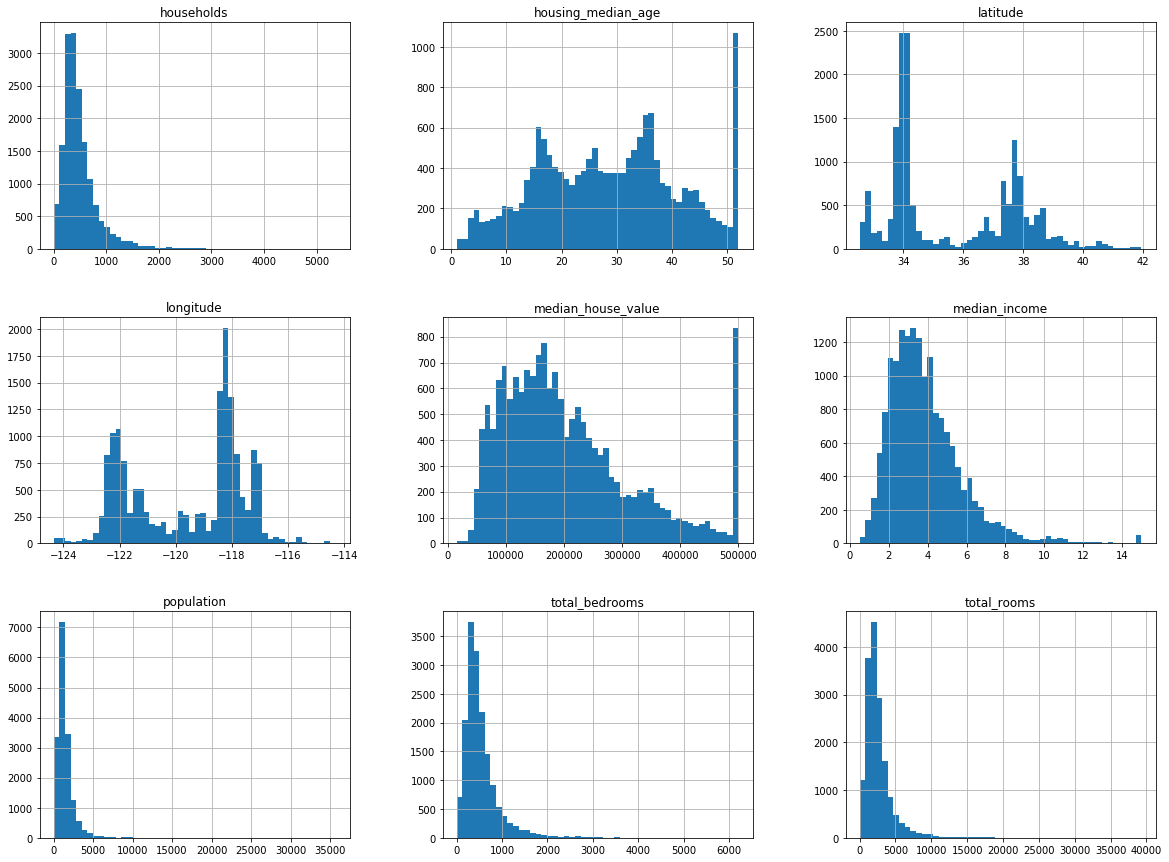

In [460]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

# We now create a test set and a train set

To do this we first look at median income, as this is very important to housing prices.
Instead of simply picking random data for the test set, we will use stratified sampling to get a test set that is accuratly represented regarding meadian income.
Most meadian income values are clustered around 2-5(tens of thousand dollars).

We will divide all median incomes into 5 categories that will be used for stratified sampling.


In [461]:
import numpy as np

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

We now have what we need to do stratified sampling on the set

In [462]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]

In [463]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

We remove the **income_cat** attribute to get our original dataset back

In [464]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

# Visualizing the data

We create a copy of the training dataset that we can play around with

In [465]:
housing = strat_train_set.copy()

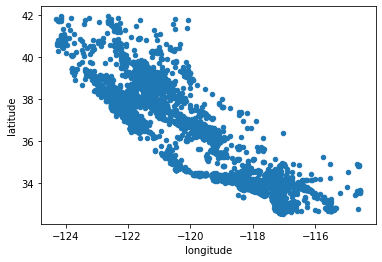

In [466]:
housing.plot(kind="scatter", x="longitude", y="latitude")

We adjust the alpha to make it easier to see where there is a high density of data points

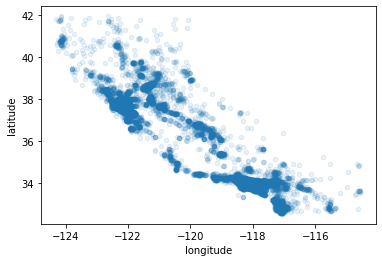

In [467]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

Now we take a look at the housing prices in the different areas

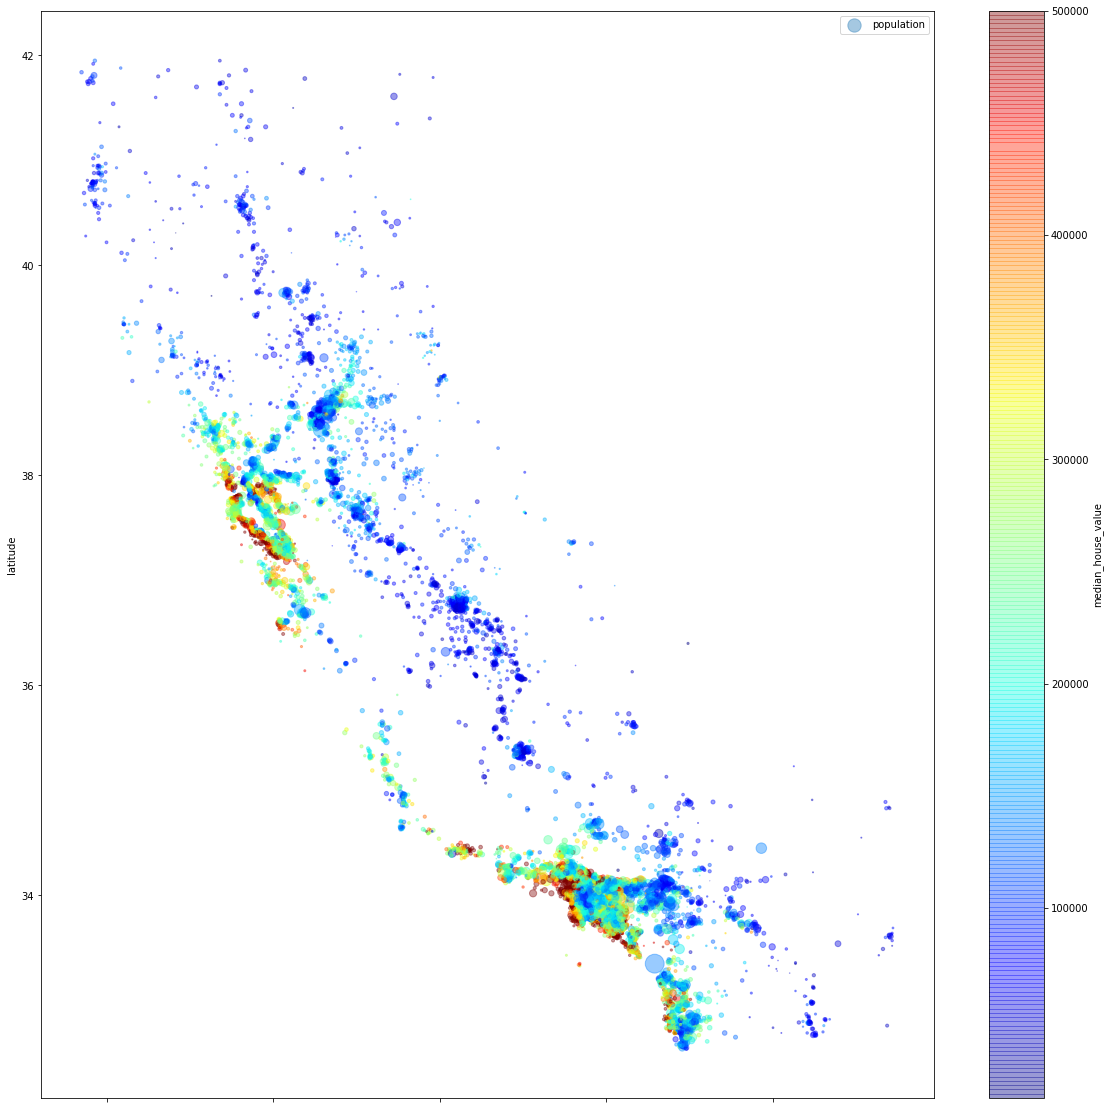

In [468]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
         s=housing["population"]/100, label="population",
         c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(20,20)
     )
plt.legend()

# Looking for correlations
We compute the standard correlation efficient between every pair of attributes.

In [469]:
corr_matrix = housing.corr()

Now let’s look at how much each attribute correlates with the median house value:

In [470]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.685704
total_rooms           0.133077
housing_median_age    0.106092
households            0.063955
total_bedrooms        0.047995
population           -0.026638
longitude            -0.041681
latitude             -0.149024
Name: median_house_value, dtype: float64

We can also look for correlations using Pandas' ```scatter_matrix``` function

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f2e9656d0>,
      dtype=object)

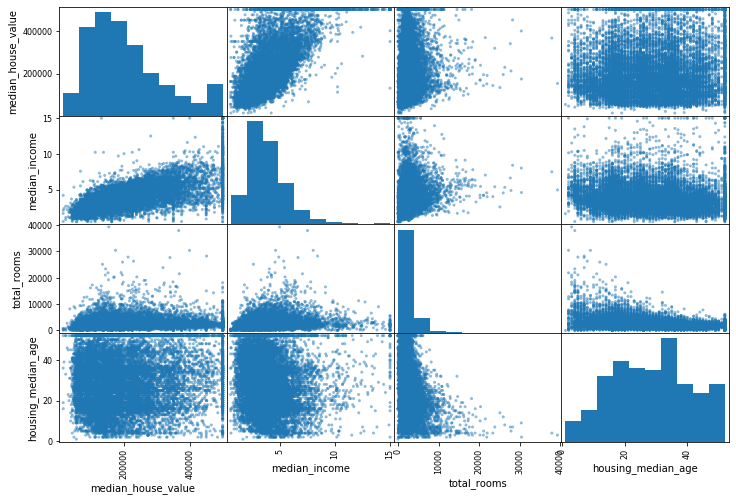

In [471]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
    "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

We zoom in on median income as this is the most promising feature

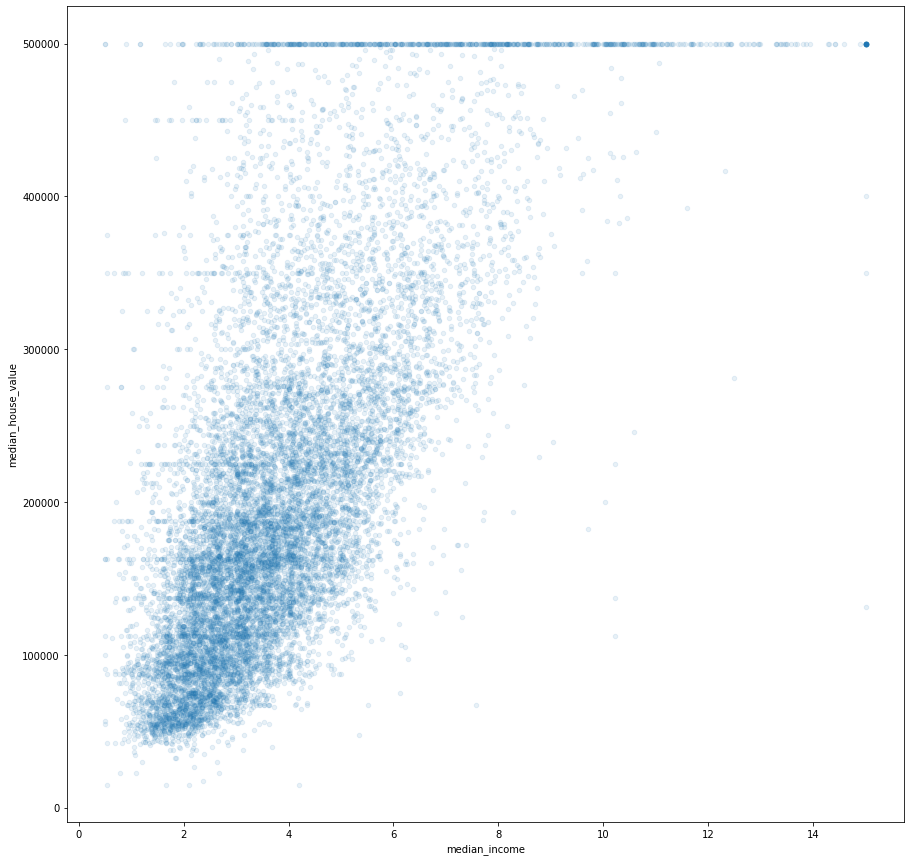

In [472]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
    alpha=0.1, figsize=(15,15))

We can clearly see the cap at 500 000$, but we also see some other horizontal lines, these might be useful to remove to avoid confusing the algorithm with these data quirks.

We create some new attributes that might prove useful to us

In [473]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [474]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.685704
rooms_per_household         0.193628
total_rooms                 0.133077
housing_median_age          0.106092
households                  0.063955
total_bedrooms              0.047995
population_per_household   -0.025622
population                 -0.026638
longitude                  -0.041681
latitude                   -0.149024
bedrooms_per_room          -0.255611
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning Algorithms

We go back to a clean dataset, and take out median house value.

In [475]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [476]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12502,-118.15,34.12,52.0,1518.0,344.0,725.0,296.0,3.4018,<1H OCEAN
3675,-117.88,34.12,34.0,912.0,165.0,522.0,150.0,4.0417,<1H OCEAN
8033,-121.09,37.33,40.0,524.0,112.0,329.0,96.0,1.7188,INLAND
10494,-118.24,33.99,41.0,1425.0,372.0,1803.0,353.0,1.6731,<1H OCEAN
1457,-122.40,37.72,37.0,971.0,248.0,647.0,208.0,2.1187,NEAR BAY


In [477]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
11433,-117.87,33.83,27.0,2287.0,NaN,1140.0,351.0,5.6163,<1H OCEAN
16207,-119.69,36.83,32.0,1098.0,NaN,726.0,224.0,1.4913,INLAND
5506,-117.65,34.04,15.0,3393.0,NaN,2039.0,611.0,3.9336,INLAND
7062,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,NEAR BAY
4672,-122.22,38.08,37.0,2811.0,NaN,1574.0,516.0,3.1053,NEAR BAY


## Data cleaning

We need to take care of missing values in the dataset.
In this case, we will calculate the median amount of bedrooms, and use this value to fill in the cells that lack any values

In [478]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

sample_incomplete_rows





,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
11433,-117.87,33.83,27.0,2287.0,433.0,1140.0,351.0,5.6163,<1H OCEAN
16207,-119.69,36.83,32.0,1098.0,433.0,726.0,224.0,1.4913,INLAND
5506,-117.65,34.04,15.0,3393.0,433.0,2039.0,611.0,3.9336,INLAND
7062,-122.17,37.75,38.0,992.0,433.0,732.0,259.0,1.6196,NEAR BAY
4672,-122.22,38.08,37.0,2811.0,433.0,1574.0,516.0,3.1053,NEAR BAY


## Handling Text and Categorical Attributes
Earlier we left out the attribute ```ocean_proximity``` because it is a text attribute. We will now convert it into a numerical attrubute, so that it can be utilized.

In [479]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)



SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [480]:
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2116.    ,  433.    , 1163.    ,
        409.    ,    3.5288])

In [481]:
housing_num.median().values

array([-118.49  ,   34.25  ,   29.    , 2116.    ,  433.    , 1163.    ,
        409.    ,    3.5288])

In [482]:
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [483]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 1, ..., 0, 0, 0])

These are the classes we just encoded

In [484]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


One issue now is that the ML algorithm will assume that two values close to each other in this list, will be close to each other in reality. This is not the case and needs to be fixed.

We also reshape the array from 1D to 2D, since the encoder takes a 2D arrays as input.

In [485]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

## Custom Transformers
here is a small transformer class that adds the combined attributes we discussed earlier

In [486]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Feature Scaling

ML algorithms generally do not perform very well when the data from the different attributes are on widely different scales. So we need to use some techniques to get them all on roughly the same scale.

In [487]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [488]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [489]:
from sklearn.base import TransformerMixin #gives fit_transform method for free
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [490]:
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', MyLabelBinarizer()),
])
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

we now run the whole pipeline

In [491]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared
housing_prepared.shape

(13209, 16)

# Select and train a model
The problem is now framed and we can start training our machine learning model

### Linear Regression
we first try out a linear regression model

In [492]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Done!**, we now have a working model. We try it out on some test data

In [493]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [229160.3070257  212665.75854606  98082.80265673 122004.73357883
 176186.91927408]
Labels:		 [204500.0, 178000.0, 112500.0, 88200.0, 239300.0]


It works, but the predictions are not very good.
We will now measure this models RMSE on the whole training set using Scikits mean_squared_error function

In [494]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69189.070349375

This number means that our typical prediction error is of about $68 000, not great considering that most house values range between $120 000 - $265 000. So our model is underfitting the data.

To fix this underfitting, we can either use a more powerful model, or we can feed the training algorithm with better features.

We will try to train a DecisionTreeRegressor, since this is a more powerful model.

In [495]:

from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')


Now that the model is trained, let’s evaluate it on the training set:

In [496]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

We get no errors. This seems to good to be true, so we are probably overfitting the data. We need to better evaluate the data to find out if we are overfitting or not.

## Better Evaluation Using Cross-Validation

This form of validation will split the training set randomly into 10 distinct subsets called *folds*, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores.

In [497]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

Let's look at the results:

In [498]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(rmse_scores)

Scores: [68501.48501269 72085.71454965 73023.989484   70094.10690995
 73067.18465854 70670.74661516 75261.68065134 74004.62295269
 71318.68102104 74631.24822257]
Mean: 72265.94600776496
Standard deviation: 2029.0687153021986


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to per‐ form worse than the Linear Regression model! Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a score of approximately 71,200, generally ±3,200. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible.

Let’s compute the same scores for the Linear Regression model just to be sure:

In [499]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
        scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [67425.31111647 70545.68245901 65275.34487036 72985.99852065
 66010.80255207 70540.06026376 73335.57983319 70614.41958818
 71803.70040712 67678.50408007]
Mean: 69621.54036908636
Standard deviation: 2703.4177001707126


We here get confirmation that the decision tree is overfitting so badly that it is actually performing worse than the linear regression model.


### Random Forrest
We will try one last model, the RandomForestRegressor. This one works by training many Decision Trees on random subsets of features, then averaging out their predictions. Building a model on top of many other models is called *Ensemble Learning*, and it is often a great way to push ML algorithms even further.

In [500]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

/Users/mikkel/anaconda3/envs/dat158/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [501]:
display_scores(forest_rmse_scores)

Scores: [52713.07144485 55187.98902645 52606.81478855 52495.69373038
 52003.99357054 56180.62917745 58382.02970958 53628.55834706
 53847.56712584 51316.72158839]
Mean: 53836.306850909794
Standard deviation: 2056.8424421230056


This is starting to look better, but we can see that the scores on the training set are still better than the scores on the validation sets, meaning the model is still overfitting.

## Fine-Tune Your Model
We will now look at a few ways to fine tune your model.


### Grid Search
One way to do that would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.
Instead you should get Scikit-Learn’s GridSearchCV to search for you. All you need to do is tell it which hyperparameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation. For example, the following code searches for the best combi‐ nation of hyperparameter values for the RandomForestRegressor:

In [502]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                        scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


All in all, the grid search will explore 12 + 6 = 18 combinations of RandomForestRe gressor hyperparameter values, and it will train each model five times (since we are using five-fold cross validation). In other words, all in all, there will be 18 × 5 = 90 rounds of training! It may take quite a long time, but when it is done you can get the best combination of parameters like this:

In [503]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

One tip here is to note that it claims using 30 estimators gave the best results. This was the highest number of estimator we used, so having more might provide even better results

You can also get the best estimator directly:

In [504]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

And of course the evaluation scores are also available:

In [505]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65615.23932241568 {'max_features': 2, 'n_estimators': 3}
56530.97215534551 {'max_features': 2, 'n_estimators': 10}
53482.510872683066 {'max_features': 2, 'n_estimators': 30}
61574.65769057963 {'max_features': 4, 'n_estimators': 3}
54236.588818760436 {'max_features': 4, 'n_estimators': 10}
51471.41881011435 {'max_features': 4, 'n_estimators': 30}
59881.25377537177 {'max_features': 6, 'n_estimators': 3}
53740.627613584096 {'max_features': 6, 'n_estimators': 10}
50937.87882429961 {'max_features': 6, 'n_estimators': 30}
59126.18134146338 {'max_features': 8, 'n_estimators': 3}
53054.81497382574 {'max_features': 8, 'n_estimators': 10}
51113.03906242162 {'max_features': 8, 'n_estimators': 30}
62948.44896536687 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54980.34351590217 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61431.091729277105 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53481.524360043586 {'bootstrap': False, 'max_features': 3, 'n_estimators

The best scores we get are around 50000 and both use 30 estimators. This is better than our previous score of about 52000.

### Randomized Search
The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combi‐ nations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.This approach has two main benefits:
- If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few val‐ ues per hyperparameter with the grid search approach).
- You have more control over the computing budget you want to allocate to hyper‐ parameter search, simply by setting the number of iterations.

Let's try:

In [506]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=50),
        'max_features': randint(low=1, high=9),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [507]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

51222.72351336434 {'max_features': 7, 'n_estimators': 29}
50877.96019771832 {'max_features': 7, 'n_estimators': 43}
51675.40781507711 {'max_features': 8, 'n_estimators': 21}
51910.63613095405 {'max_features': 7, 'n_estimators': 19}
53168.01471649754 {'max_features': 7, 'n_estimators': 11}
52724.32474397169 {'max_features': 3, 'n_estimators': 24}
51055.16874749116 {'max_features': 5, 'n_estimators': 36}
51542.02431156882 {'max_features': 8, 'n_estimators': 24}
52854.052818310956 {'max_features': 3, 'n_estimators': 22}
66478.79205406658 {'max_features': 5, 'n_estimators': 2}


In [508]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([7.13688970e-02, 6.14738327e-02, 4.15999770e-02, 1.61796725e-02,
       1.62618353e-02, 1.64001108e-02, 1.57283805e-02, 3.35405052e-01,
       5.85879169e-02, 1.12700492e-01, 7.50964339e-02, 8.59085028e-03,
       1.64638332e-01, 2.74488674e-04, 2.12361971e-03, 3.57010815e-03])

In [509]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.33540505248425745, 'median_income'),
 (0.16463833216930374, 'INLAND'),
 (0.1127004919564583, 'pop_per_hhold'),
 (0.07509643388772134, 'bedrooms_per_room'),
 (0.07136889703313647, 'longitude'),
 (0.06147383268720076, 'latitude'),
 (0.0585879169258272, 'rooms_per_hhold'),
 (0.04159997697995252, 'housing_median_age'),
 (0.016400110758804896, 'population'),
 (0.01626183530817781, 'total_bedrooms'),
 (0.016179672474297958, 'total_rooms'),
 (0.015728380525310375, 'households'),
 (0.008590850278259284, '<1H OCEAN'),
 (0.003570108151835639, 'NEAR OCEAN'),
 (0.002123619705050587, 'NEAR BAY'),
 (0.0002744886744058558, 'ISLAND')]

# Trying to make a better pipeline
this one will only use the most important attributes, since we found them running randomsearch previuously

In [510]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [524]:
k = 9

In [525]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  2,  5,  7,  8,  9, 10, 12])

In [526]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.33540505248425745, 'median_income'),
 (0.16463833216930374, 'INLAND'),
 (0.1127004919564583, 'pop_per_hhold'),
 (0.07509643388772134, 'bedrooms_per_room'),
 (0.07136889703313647, 'longitude'),
 (0.06147383268720076, 'latitude'),
 (0.0585879169258272, 'rooms_per_hhold'),
 (0.04159997697995252, 'housing_median_age'),
 (0.016400110758804896, 'population')]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [527]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [528]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [529]:
housing_prepared_top_k_features[0:3]

array([[ 0.70797764, -0.70363879,  1.85738628, -0.62122729, -0.24724548,
        -0.13949335, -0.05343806,  0.19305162,  0.        ],
       [ 0.84318493, -0.70363879,  0.42224052, -0.8005011 ,  0.08783067,
         0.36109452,  0.03117542, -0.50017146,  0.        ],
       [-0.76427942,  0.80262716,  0.90062244, -0.97094368, -1.12852874,
         0.03407506,  0.02683122, -0.00225684,  1.        ]])

In [530]:
housing_prepared[0:3, top_k_feature_indices]

array([[ 0.70797764, -0.70363879,  1.85738628, -0.62122729, -0.24724548,
        -0.13949335, -0.05343806,  0.19305162,  0.        ],
       [ 0.84318493, -0.70363879,  0.42224052, -0.8005011 ,  0.08783067,
         0.36109452,  0.03117542, -0.50017146,  0.        ],
       [-0.76427942,  0.80262716,  0.90062244, -0.97094368, -1.12852874,
         0.03407506,  0.02683122, -0.00225684,  1.        ]])

In [532]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=29, high=30),
        'max_features': randint(low=1, high=10),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared_top_k_features, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [533]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

51583.06484208908 {'max_features': 7, 'n_estimators': 29}
50460.97933233077 {'max_features': 4, 'n_estimators': 29}
51845.48038401847 {'max_features': 8, 'n_estimators': 29}
51001.762435801844 {'max_features': 5, 'n_estimators': 29}
51583.06484208908 {'max_features': 7, 'n_estimators': 29}
50077.03953693942 {'max_features': 3, 'n_estimators': 29}
51583.06484208908 {'max_features': 7, 'n_estimators': 29}
51845.48038401847 {'max_features': 8, 'n_estimators': 29}
51001.762435801844 {'max_features': 5, 'n_estimators': 29}
50460.97933233077 {'max_features': 4, 'n_estimators': 29}
51845.48038401847 {'max_features': 8, 'n_estimators': 29}
51845.48038401847 {'max_features': 8, 'n_estimators': 29}
50077.03953693942 {'max_features': 3, 'n_estimators': 29}
51210.703651377866 {'max_features': 6, 'n_estimators': 29}
51001.762435801844 {'max_features': 5, 'n_estimators': 29}
51289.06282578199 {'max_features': 2, 'n_estimators': 29}
51845.48038401847 {'max_features': 8, 'n_estimators': 29}
51210.7036

In [534]:
rnd_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=29,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

## Evaluate Your System On The Test Set

In [535]:
final_model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)
final_model.fit(housing_prepared_top_k_features, housing_labels)
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = preparation_and_feature_selection_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48486.61462562017

# Prepare submission


In [537]:
test_prepared = preparation_and_feature_selection_pipeline.transform(housing_test)
median_house_value = final_model.predict(test_prepared)
submission = pd.DataFrame({'Id': housing_test['Id'], 'median_house_value': median_house_value})
submission.head()

,Id,median_house_value
0,0,229597.221667
1,1,250467.000000
2,2,74323.166667
3,3,170836.003333
4,4,53636.000000


In [538]:
submission.to_csv('submission_1.csv', index=False)